# Ice trends
Show the trends in sea ice. Based on the sidads dataset.

In [1]:
import pathlib
import datetime

import numpy as np
import pandas as pd

import rasterio
import rasterio.plot

import matplotlib.pyplot as plt
import matplotlib.colors
import cmocean
import colorcet

import statsmodels.tsa.seasonal
import statsmodels.tsa

%matplotlib inline

In [2]:
# load datasets
data_dir = pathlib.Path('~/src/sealevel/data/sidads/').expanduser()
data_paths = list(data_dir.glob('*extent_v3.0.csv'))

In [3]:
# read data, drop nans
dfs = []
for path in data_paths:
    df = pd.read_csv(path, skipinitialspace=True, na_values=[-9999])
    dfs.append(df)
    
# concatenate
merged = pd.concat(dfs)
# clean up columns
merged = merged.rename({'mo': 'month'}, axis='columns')
# convert to date
merged['day'] = 1
merged['date'] = pd.to_datetime(merged[['year', 'month', 'day']])

# split in north and south
nh_df = merged[merged.region == 'N'].sort_values('date').set_index('date')
sh_df = merged[merged.region == 'S'].sort_values('date').set_index('date')

# fill in missings based on previous year
quantities = ['area', 'extent']
sh_df.loc[datetime.date(1987, 12, 1), quantities] = sh_df.loc[datetime.date(1986, 12, 1), quantities]
sh_df.loc[datetime.date(1988, 1, 1), quantities] = sh_df.loc[datetime.date(1987, 1, 1), quantities]
nh_df.loc[datetime.date(1987, 12, 1), quantities] = nh_df.loc[datetime.date(1986, 12, 1), quantities]
nh_df.loc[datetime.date(1987, 8, 1), 'area'] = nh_df.loc[datetime.date(1986, 8, 1), 'area']
nh_df.loc[datetime.date(1988, 1, 1), quantities] = nh_df.loc[datetime.date(1987, 1, 1), quantities]

# fit seasonal model
sh_fit = statsmodels.tsa.seasonal.seasonal_decompose(sh_df['area'], freq=12)
nh_fit = statsmodels.tsa.seasonal.seasonal_decompose(nh_df['area'], freq=12)

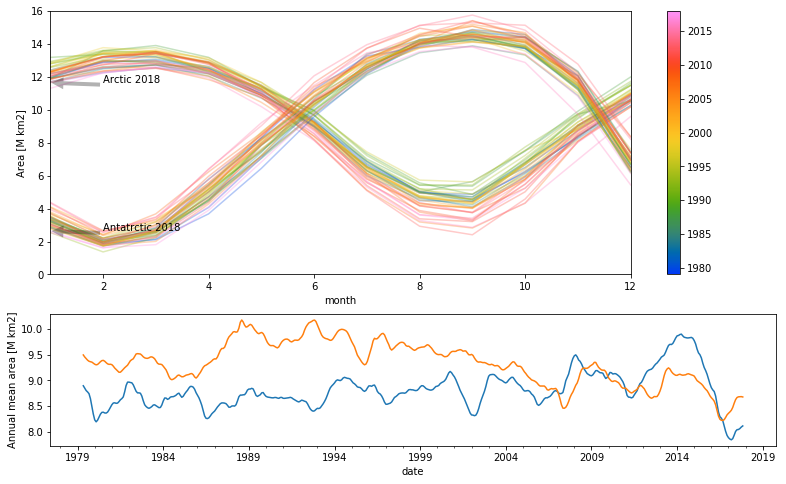

In [4]:
# create a plot
fig, axes = plt.subplots(nrows=2, figsize=(13, 8), gridspec_kw=dict(height_ratios=(2, 1)))
N = matplotlib.colors.Normalize(1979, 2018)
cmap = colorcet.m_rainbow_bgyrm_35_85_c71
# add the lines
for year, nh_df_i in nh_df.groupby('year'):
    nh_df_i.set_index('month').area.plot(label='Arctic', alpha=0.3, color=cmap(N(year)), ax=axes[0])
for year, sh_df_i in sh_df.groupby('year'):
    sh_df_i.set_index('month').area.plot(label='Antarctic', alpha=0.3, color=cmap(N(year)), ax=axes[0])

# annotate last value
nh_last = nh_df[nh_df.month == 1].sort_index().iloc[-1]
sh_last = sh_df[sh_df.month == 1].sort_index().iloc[-1]

axes[0].annotate('Arctic %s' % nh_last.year, xy=(nh_last.month, nh_last.area), xytext=(nh_last.month+1, nh_last.area), horizontalalignment='left', arrowprops=dict(facecolor=(0, 0, 0, 0.3), shrink=0.02, edgecolor='none'))
axes[0].annotate('Antatrctic %s' % sh_last.year, xy=(sh_last.month, sh_last.area), xytext=(sh_last.month+1, sh_last.area), horizontalalignment='left', arrowprops=dict(facecolor=(0, 0, 0, 0.3), shrink=0.02, edgecolor='none'))

# add dummy for colorbar
sc = axes[0].scatter([nh_last.month], [nh_last.area], c=[1], alpha=1, cmap=cmap, vmin=1979, vmax=2018)
sc.remove()

axes[0].set_xlim(1, 12)
axes[0].set_ylim(0, 16)
axes[0].set_ylabel('Area [M km2]')

sh_fit.trend.plot(label="Antarctic (-season)", ax=axes[1])
nh_fit.trend.plot(label="Arctic (-season)", ax=axes[1])

axes[1].set_ylabel('Annual mean area [M km2]')

plt.colorbar(sc, ax=axes[0])
plt.savefig('ice-trend.pdf')

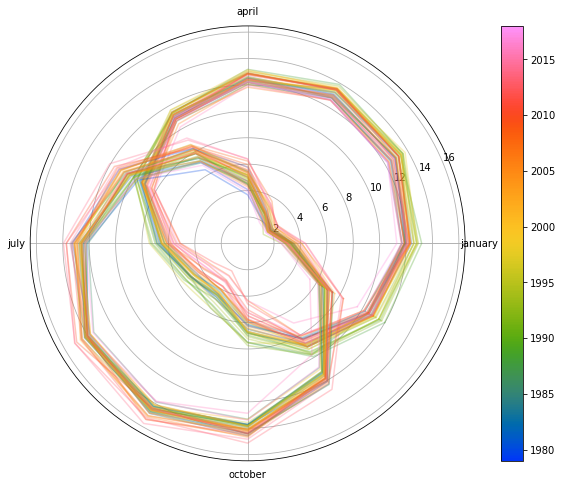

In [5]:
# different type of plot, not used
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(13, 8))
for year, nh_df_i in nh_df.groupby('year'):
    nh_df_i = pd.concat([
        nh_df[np.logical_and(nh_df.year == (year - 1), nh_df.month==12)],
        nh_df_i
    ])
            
    ax.plot(
        (nh_df_i.month-1)/12 * np.pi * 2, 
        nh_df_i.area,
        label='Arctic', 
        alpha=0.3, 
        color=cmap(N(year))
    )
for year, sh_df_i in sh_df.groupby('year'):
    sh_df_i = pd.concat([
        sh_df[np.logical_and(sh_df.year == (year - 1), sh_df.month==12)],
        sh_df_i
    ])
            
    ax.plot(
        (sh_df_i.month-1)/12 * np.pi * 2, 
        sh_df_i.area,
        label='Arctic', 
        alpha=0.3, 
        color=cmap(N(year))
    )
ax.set_thetagrids(np.linspace(0, 360, num=5), labels=('january', 'april', 'july', 'october'))

sc = ax.scatter([nh_last.month], [nh_last.area], c=[1], alpha=1, cmap=cmap, vmin=1979, vmax=2018)
sc.remove()
plt.colorbar(sc, ax=ax)


# ax.set_xlim(0, 12)
# ax.grid(True)